In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

#### Helper Functions

In [3]:
def plot_isis(single_neuron_isis):
  plt.hist(single_neuron_isis, bins=50, histtype="stepfilled")
  plt.axvline(single_neuron_isis.mean(), color="orange", label="Mean ISI")
  plt.xlabel("ISI duration (s)")
  plt.ylabel("Number of spikes")
  plt.legend()

In [4]:
# @markdown Execute this cell for helper function `restrict_spike_times`
def restrict_spike_times(spike_times, interval):
  """Given a spike_time dataset, restrict to spikes within given interval.

  Args:
    spike_times (sequence of np.ndarray): List or array of arrays,
      each inner array has spike times for a single neuron.
    interval (tuple): Min, max time values; keep min <= t < max.

  Returns:
    np.ndarray: like `spike_times`, but only within `interval`
  """
  interval_spike_times = []
  for spikes in spike_times:
    interval_mask = (spikes >= interval[0]) & (spikes < interval[1])
    interval_spike_times.append(spikes[interval_mask])
  return np.array(interval_spike_times, object)

In [5]:
def exponential(xs, scale, rate, x0):
  """A simple parameterized exponential function, applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    scale (float): Linear scaling factor.
    rate (float): Exponential growth (positive) or decay (negative) rate.
    x0 (float): Horizontal offset.

  """
  ys = scale * np.exp(rate * (xs - x0))
  return ys

def inverse(xs, scale, x0):
  """A simple parameterized inverse function (`1/x`), applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    scale (float): Linear scaling factor.
    x0 (float): Horizontal offset.

  """
  ys = scale / (xs - x0)
  return ys

def linear(xs, slope, y0):
  """A simple linear function, applied element-wise.

  Args:
    xs (np.ndarray or float): Input(s) to the function.
    slope (float): Slope of the line.
    y0 (float): y-intercept of the line.

  """
  ys = slope * xs + y0
  return ys

In [6]:
#@title Data retrieval
#@markdown This cell downloads the example dataset that we will use in this tutorial.
import io
import requests
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Failed to download data')
  spike_times = np.load('../data/spike_times.npz', allow_pickle=True)['spike_times']
else:
  spike_times = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

#### Data Exploration

In [7]:
# vector<vector<float>>
print(type(spike_times), spike_times.shape, spike_times[0].shape)
n_neurons = len(spike_times)
total_spikes_per_neuron = [len(spike_times_i) for spike_times_i in spike_times]

print(f"Number of neurons: {n_neurons}")
print(f"Number of spikes for first five neurons: {total_spikes_per_neuron[:5]}")

<class 'numpy.ndarray'> (734,) (826,)
Number of neurons: 734
Number of spikes for first five neurons: [826, 2818, 3953, 646, 1115]


In [8]:
mean_spike_count = np.mean(total_spikes_per_neuron)
median_spike_count = np.median(total_spikes_per_neuron)

frac_below_mean = (total_spikes_per_neuron < mean_spike_count).mean()
print(f"{frac_below_mean:2.1%} of neurons are below the mean")

68.0% of neurons are below the mean


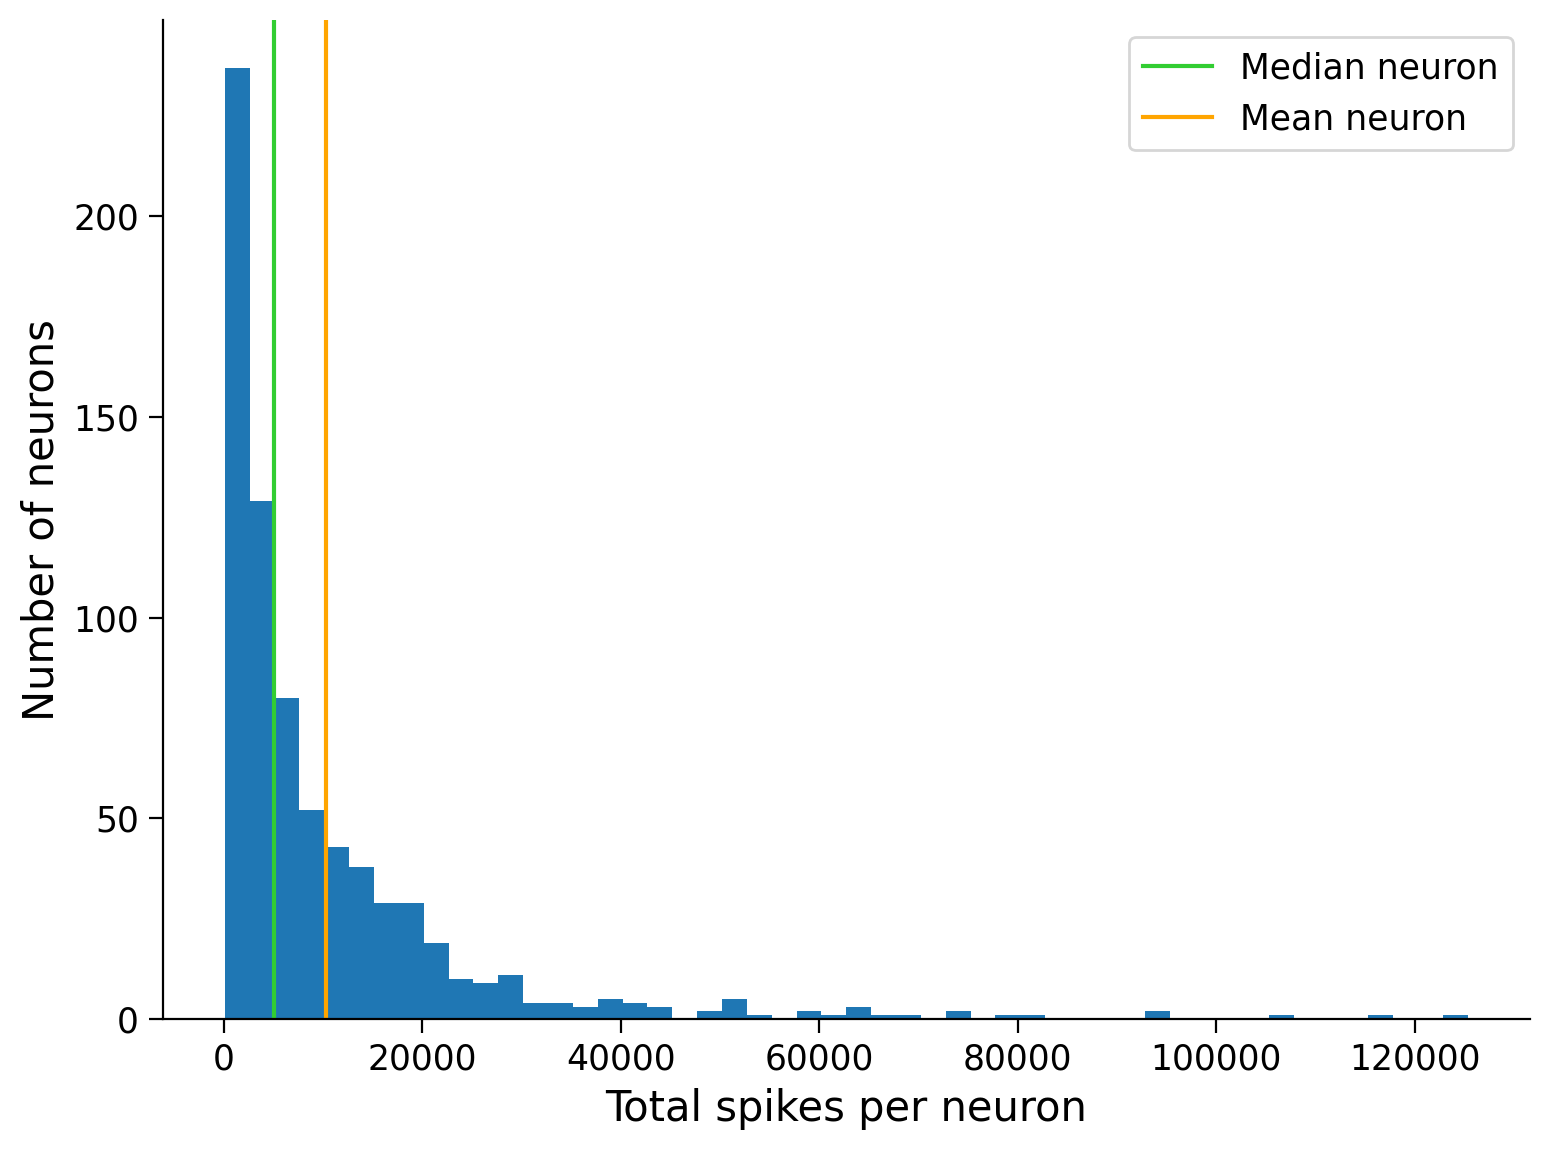

In [9]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.axvline(median_spike_count, color="limegreen", label="Median neuron")
plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
plt.legend();

In [10]:
t_interval = (5, 15)  # units are seconds after start of recording
interval_spike_times = restrict_spike_times(spike_times, t_interval)

In [11]:
original_counts = sum([len(spikes) for spikes in spike_times])
interval_counts = sum([len(spikes) for spikes in interval_spike_times])
frac_interval_spikes = interval_counts / original_counts
print(f"{frac_interval_spikes:.2%} of the total spikes are in the interval")

0.33% of the total spikes are in the interval


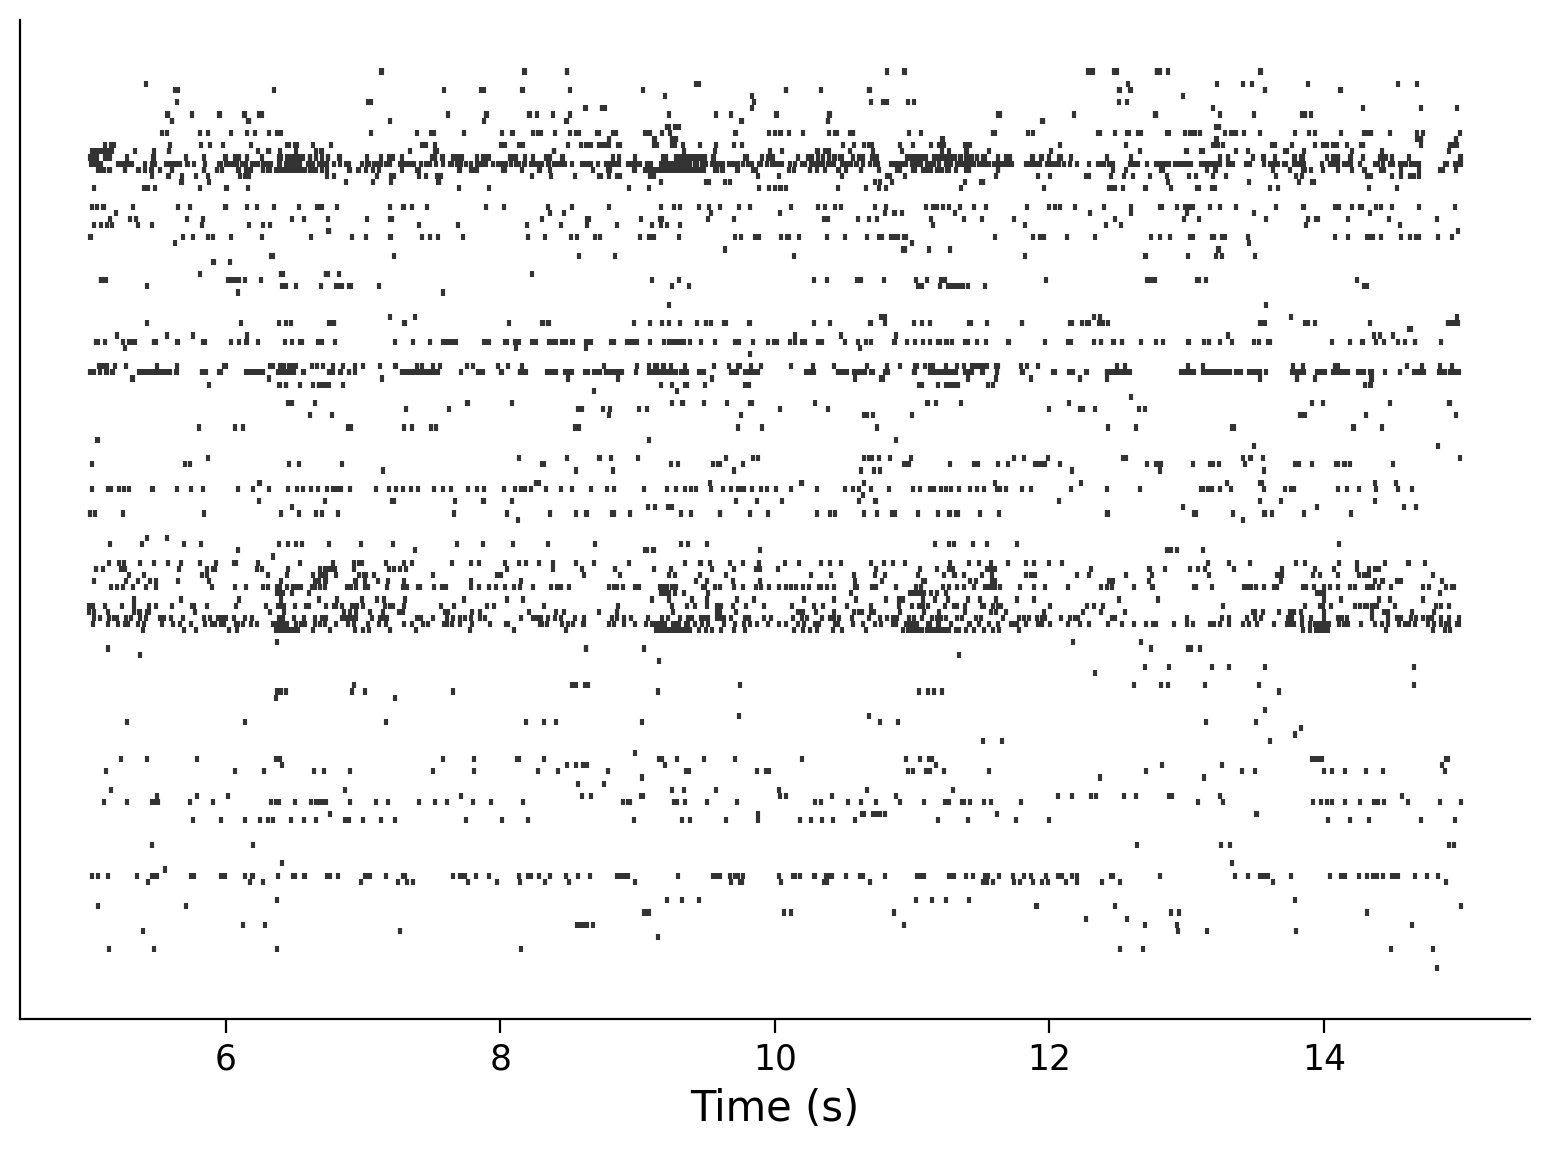

In [12]:
neuron_idx = np.arange(0, len(spike_times), 5)
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

#### Ex1 ISI

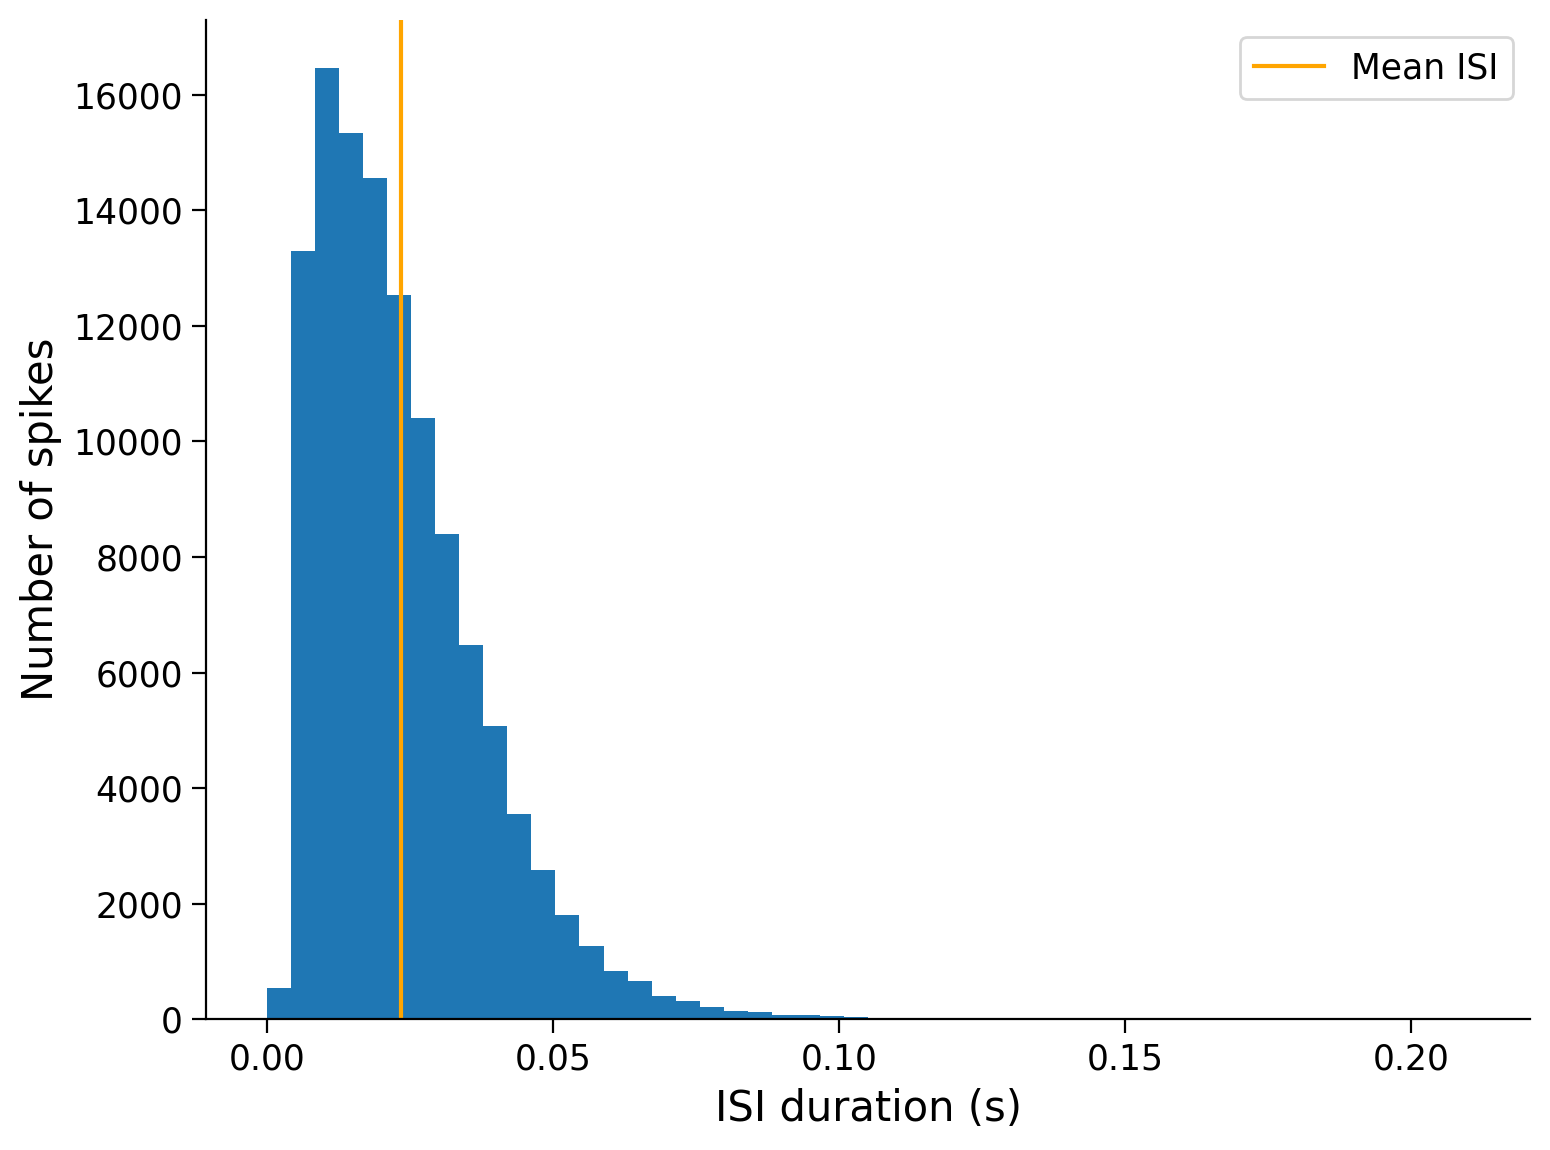

In [13]:
def compute_single_neuron_isis(spike_times, neuron_idx):
  """Compute a vector of ISIs for a single neuron given spike times.

  Args:
    spike_times (list of 1D arrays): Spike time dataset, with the first
      dimension corresponding to different neurons.
    neuron_idx (int): Index of the unit to compute ISIs for.

  Returns:
    isis (1D array): Duration of time between each spike from one neuron.
  """
  
  # Extract the spike times for the specified neuron
  single_neuron_spikes = spike_times[neuron_idx]

  # Compute the ISIs for this set of spikes
  # Hint: the function np.diff computes discrete differences along an array
  isis = np.diff(single_neuron_spikes)

  return isis

# Compute ISIs
single_neuron_isis = compute_single_neuron_isis(spike_times, neuron_idx=283)

# Visualize ISIs
plot_isis(single_neuron_isis)

#### Demo ISI function

In [ ]:
single_neuron_idx = 283
single_neuron_spikes = spike_times[single_neuron_idx]
single_neuron_isis = np.diff(single_neuron_spikes)

counts, edges = np.histogram(
  single_neuron_isis,
  bins=50,
  range=(0, single_neuron_isis.max())
)

functions = dict(
  exponential=exponential,
  inverse=inverse,
  linear=linear,
)

colors = dict(
  exponential="C1",
  inverse="C2",
  linear="C4",
)

@widgets.interact(
  exp_scale=widgets.FloatSlider(1000, min=0, max=20000, step=250),
  exp_rate=widgets.FloatSlider(-10, min=-200, max=50, step=1),
  exp_x0=widgets.FloatSlider(0.1, min=-0.5, max=0.5, step=0.005),
  inv_scale=widgets.FloatSlider(1000, min=0, max=3e2, step=10),
  inv_x0=widgets.FloatSlider(0, min=-0.2, max=0.2, step=0.01),
  lin_slope=widgets.FloatSlider(-1e5, min=-6e5, max=1e5, step=10000),
  lin_y0=widgets.FloatSlider(10000, min=0, max=4e4, step=1000),
)
def fit_plot(
  exp_scale=1000, exp_rate=-10, exp_x0=0.1,
  inv_scale=1000, inv_x0=0,
  lin_slope=-1e5, lin_y0=2000,
):
  """Helper function for plotting function fits with interactive sliders."""
  func_params = dict(
    exponential=(exp_scale, exp_rate, exp_x0),
    inverse=(inv_scale, inv_x0),
    linear=(lin_slope, lin_y0),
  )
  f, ax = plt.subplots()
  ax.fill_between(edges[:-1], counts, step="post", alpha=.5)
  xs = np.linspace(1e-10, edges.max())
  for name, function in functions.items():
    ys = function(xs, *func_params[name])
    ax.plot(xs, ys, lw=3, color=colors[name], label=name);
  ax.set(
      xlim=(edges.min(), edges.max()),
      ylim=(0, counts.max() * 1.1),
      xlabel="ISI (s)",
      ylabel="Number of spikes",
  )
  ax.legend()
  plt.show()

interactive(children=(FloatSlider(value=1000.0, description='exp_scale', max=20000.0, step=250.0), FloatSlider…